## Using CNN to extract features from resulting Spectrogram
Note that the CNN is independent from the features acquired by feature extraction; it will depend solely on the spectrograms to learn features of emotion in audio data.

Created code so that it stores spectrogram as a tensor only(no need to generate a full image to input to CNN). Code to generate images are provided below, but only as comments(no need to run).

In [1]:
# Necessary imports
import os
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.models import resnet101
# get location of audio files
root_directory = os.getcwd()
print(root_directory)

/storage/ice1/7/4/hyang491/PCA_Audio


In [ ]:
# Generate spectrogram and save it as a tensor
def generate_spectrogram_tensor(audio_path, save_dir=None, n_fft=2048, hop_length=512, sr=22050, frame_length=0.03, frame_overlap=0.015):
    """
    Parameters:
        audio_path (str): Path to the audio file.
        save_dir (str): Directory to save the spectrogram tensor. If None, it won't save the tensor.
        n_fft (int): Number of FFT components (window size).
        hop_length (int): Number of samples between successive frames.
        sr (int): Sampling rate to load the audio file.
        frame_length (float): Length of each frame in seconds.
        frame_overlap (float): Overlap duration between frames in seconds.

    Returns:
        spectrogram_tensor (torch.Tensor): Spectrogram data as a tensor.
    """
    y, sr = librosa.load(audio_path, sr=sr)

    # Calculate frame parameters
    frame_length_samples = int(sr * frame_length)
    frame_step = frame_length_samples - int(sr * frame_overlap)

    # Apply framing and Hamming window
    frames = librosa.util.frame(y, frame_length=frame_length_samples, hop_length=frame_step)
    hamming_window = np.hamming(frame_length_samples)
    windowed_frames = frames * hamming_window[:, np.newaxis]

    # Compute Short-Time Fourier Transform
    stft = np.array([librosa.stft(frame, n_fft=n_fft, hop_length=hop_length) for frame in windowed_frames])
    spectrogram = np.abs(stft)
    spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)

    # Convert spectrogram to a tensor
    spectrogram_tensor = torch.tensor(spectrogram_db, dtype=torch.float32)

    # Save the spectrogram tensor if a save directory is provided
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        base_name = os.path.splitext(os.path.basename(audio_path))[0]
        save_path = os.path.join(save_dir, f"{base_name}_spectrogram.pt")
        torch.save(spectrogram_tensor, save_path)
        print(f"Spectrogram tensor saved to {save_path}")

    return spectrogram_tensor

# Get all audio files in a directory and generate spectrogram tensors.
def process_audio_files_to_tensors(audio_dir, save_dir=None):
    """
    Parameters:
        audio_dir (str): Directory containing audio files.
        save_dir (str): Directory to save the spectrogram tensors. If None, it won't save the tensors.
    """
    for root, _, files in os.walk(audio_dir):
        for file_name in files:
            file_path = os.path.join(root, file_name)
            if file_name.endswith('.wav'):
                print(f"Processing {file_path}...")
                generate_spectrogram_tensor(file_path, save_dir=save_dir)

# Apply time shifting to spectrogram.
def time_shift_spectrogram(spectrogram, shift_rate):
    """
    Parameters:
        spectrogram (torch.Tensor): Input spectrogram.
        shift_rate (float): Rate of time shifting as a fraction of total length.

    Returns:
        torch.Tensor: Time-shifted spectrogram.
    """
    shift_amount = int(spectrogram.shape[-1] * shift_rate)
    return torch.roll(spectrogram, shifts=shift_amount, dims=-1)

In [3]:
# Code to save spectrogram TENSOR files
# audio_directory = os.path.join(root_directory, 'ravdess')
# nr_directory = os.path.join(root_directory, 'ravdess_NR')
# Create dir to save spectrograms
# Possible to use shutil to delete folders by script, but left it manual for safety
spectro_org_path = os.path.join(root_directory, 'org_spectrograms_tensor')
spectro_nr_path = os.path.join(root_directory, 'nr_spectrograms_tensor')
if os.path.exists(spectro_org_path):
    print(f"Folder 'org_spectrograms_tensor' already exists, checking if it has all 1440 spectrograms...")
    count = 0
    for root, _, files in os.walk(spectro_org_path):
        for file_name in files:
            file_path = os.path.join(root, file_name)
            if file_name.endswith('.pt'):
                count += 1
    print(f"Total number of .pt files in {spectro_org_path}: {count}")
    if count == 1440:
        print("All 1440 files are intact, skipping generating spectrograms for original data.")
    elif count < 1440:
        print(f"Need 1440 files, {1440-count} files missing; please delete folder and run script again to regenerate spectrograms.")
    else:
        print(f"Need 1440 files, but folder has {count-1440} additional files; please delete folder and run script again to regenerate spectrograms.")
else:
    os.makedirs(spectro_org_path, exist_ok=True)
    # Process files
    process_audio_files_to_tensors(audio_directory, save_dir=spectro_org_path)

if os.path.exists(spectro_nr_path):
    print(f"Folder 'nr_spectrograms_tensor' already exists, checking if it has all 1440 spectrograms...")
    count = 0
    for root, _, files in os.walk(spectro_nr_path):
        for file_name in files:
            file_path = os.path.join(root, file_name)
            if file_name.endswith('.pt'):
                count += 1
    print(f"Total number of .pt files in {spectro_nr_path}: {count}")
    if count == 1440:
        print("All 1440 files are intact, skipping generating spectrograms for original data.")
    elif count < 1440:
        print(f"Need 1440 files, {1440-count} files missing; please delete folder and run script again to regenerate spectrograms.")
    else:
        print(f"Need 1440 files, but folder has {count-1440} additional files; please delete folder and run script again to regenerate spectrograms.")
else:
    os.makedirs(spectro_nr_path, exist_ok=True)
    # Process files
    process_audio_files_to_tensors(nr_directory, save_dir=spectro_nr_path)

Folder 'org_spectrograms_tensor' already exists, checking if it has all 1440 spectrograms...
Total number of .pt files in /storage/ice1/7/4/hyang491/PCA_Audio/org_spectrograms_tensor: 1440
All 1440 files are intact, skipping generating spectrograms for original data.
Folder 'nr_spectrograms_tensor' already exists, checking if it has all 1440 spectrograms...
Total number of .pt files in /storage/ice1/7/4/hyang491/PCA_Audio/nr_spectrograms_tensor: 1440
All 1440 files are intact, skipping generating spectrograms for original data.


In [ ]:
# Get min/max length of spectrogram length for both original and noise-reduced data
def get_spectrogram_length_stats(directory):
    """
    Parameters:
        directory (str): Path to the directory containing spectrogram tensors.

    Returns:
        min_length (int): Minimum spectrogram length.
        max_length (int): Maximum spectrogram length.
    """
    min_length = float('inf')
    max_length = float('-inf')

    for file_name in os.listdir(directory):
        if file_name.endswith('.pt'):
            tensor_path = os.path.join(directory, file_name)
            spectrogram = torch.load(tensor_path)
            length = spectrogram.shape[-1]

            min_length = min(min_length, length)
            max_length = max(max_length, length)

    return min_length, max_length

spectro_org_path = os.path.join(root_directory, 'org_spectrograms_tensor')
spectro_nr_path = os.path.join(root_directory, 'nr_spectrograms_tensor')
org_min, org_max = get_spectrogram_length_stats(spectro_org_path)
nr_min, nr_max = get_spectrogram_length_stats(spectro_nr_path)

print(f"Original Spectrograms - Min Length: {org_min}, Max Length: {org_max}")
print(f"Noise-Reduced Spectrograms - Min Length: {nr_min}, Max Length: {nr_max}")

Original Spectrograms - Min Length: 127, Max Length: 228
Noise-Reduced Spectrograms - Min Length: 127, Max Length: 228


In [ ]:
# Wrapper class for all spectrogram tensor dataset
class SpectrogramDataset(Dataset):
    def __init__(self, tensor_dir, target_length=None):
        """
        Parameters:
            tensor_dir (str): Directory containing tensor files.
            target_length (int): The fixed length for all tensors. If None, uses the length of the shortest tensor.
        """
        self.tensor_dir = tensor_dir
        self.tensor_files = [f for f in os.listdir(tensor_dir) if f.endswith('.pt')]
        self.target_length = target_length

        if self.target_length is None:
            self.target_length = min(torch.load(os.path.join(tensor_dir, f)).shape[1] for f in self.tensor_files)

    # Function for getting length
    def __len__(self):
        return len(self.tensor_files)

    # Function for getting item
    def __getitem__(self, idx):
        tensor_path = os.path.join(self.tensor_dir, self.tensor_files[idx])
        spectrogram = torch.load(tensor_path).unsqueeze(0)  # Add channel dimension
        file_name = os.path.basename(tensor_path)
        label = int(file_name.split('-')[2]) - 1

        spectrogram = self._pad_or_trim(spectrogram, self.target_length)
        return spectrogram, label

    # Function to apply padding/trimming to tensor. Used for preprocessing.
    def _pad_or_trim(self, tensor, target_length):
        current_length = tensor.shape[-1]

        if current_length < target_length:
            padding = target_length - current_length
            tensor = torch.nn.functional.pad(tensor, (0, padding), "constant", 0)
        elif current_length > target_length:
            tensor = tensor[:, :, :target_length]

        return tensor

In [6]:
# Create training and testing dataset
spectro_org_path = os.path.join(root_directory, 'org_spectrograms_tensor')
org_dataset = SpectrogramDataset(spectro_org_path, target_length=228)

In [ ]:
# Training = 70%, Testing = 30%
# Will not use validation in this case
# MAKE SURE TO DIFFERENTIATE ORG and NR, TRAIN and TEST loader
train_size = int(0.7 * len(org_dataset))
test_size = len(org_dataset) - train_size
org_train_dataset, org_test_dataset = random_split(org_dataset, [train_size, test_size])

org_train_loader = DataLoader(org_train_dataset, batch_size=64, shuffle=True)
org_test_loader = DataLoader(org_test_dataset, batch_size=64, shuffle=False)

In [ ]:
# import stuff just in case
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet101
from tqdm import tqdm

In [ ]:
# Hyperparameters: feel free to change stuff
# Note that if u don't use gradient clipping, the model likes gradient explosion         
num_epochs = 150
max_grad_norm = 1.0  # Gradient clipping threshold
learning_rate = 1e-4  # Learning rate
target_loss = 0.001 # Target loss value, training stops if it meets this threshold

# Instantiate model and settings
model = resnet101(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 8)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create checkpoint
checkpoint_path = "resnet101_checkpoint_org.pth"
start_epoch = 0
if torch.cuda.is_available():
    device = torch.device("cuda")
    model = model.to(device)
else:
    device = torch.device("cpu")

# If checkpoint exists, run that
try:
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}")
except FileNotFoundError:
    print("No checkpoint found. Starting from scratch.")

# Run training
# MAKE SURE TO DIFFERENTIATE ORG and NR, TRAIN and TEST loader
for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, labels in org_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Verify labels are within range (included in case someone messes up emotion labels)
        if labels.min() < 0 or labels.max() > 7:
            raise ValueError("Labels are out of the expected range (0 to 7).")

        optimizer.zero_grad()
        outputs = model(inputs)

        # Check for NaN in outputs
        if torch.isnan(outputs).any():
            print("NaN detected in model outputs.")
            break

        loss = criterion(outputs, labels)

        # Check for NaN in loss
        if torch.isnan(loss):
            print("NaN detected in loss. Stopping training.")
            break
            
        # print(f"Loss: {loss.item()}")

        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(org_train_loader)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}")

    # Save checkpoint
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_loss
    }, checkpoint_path)
    print(f"Checkpoint saved for epoch {epoch + 1}")
    
    # If loss <= target_loss, stop training
    if train_loss <= target_loss:
        break


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


No checkpoint found. Starting from scratch.
Epoch 1, Train Loss: 1.8617
Checkpoint saved for epoch 1
Epoch 2, Train Loss: 1.3595
Checkpoint saved for epoch 2
Epoch 3, Train Loss: 0.8546
Checkpoint saved for epoch 3
Epoch 4, Train Loss: 0.4300
Checkpoint saved for epoch 4
Epoch 5, Train Loss: 0.1622
Checkpoint saved for epoch 5
Epoch 6, Train Loss: 0.0900
Checkpoint saved for epoch 6
Epoch 7, Train Loss: 0.0646
Checkpoint saved for epoch 7
Epoch 8, Train Loss: 0.0531
Checkpoint saved for epoch 8
Epoch 9, Train Loss: 0.0696
Checkpoint saved for epoch 9
Epoch 10, Train Loss: 0.0633
Checkpoint saved for epoch 10
Epoch 11, Train Loss: 0.0838
Checkpoint saved for epoch 11
Epoch 12, Train Loss: 0.0510
Checkpoint saved for epoch 12
Epoch 13, Train Loss: 0.0407
Checkpoint saved for epoch 13
Epoch 14, Train Loss: 0.0478
Checkpoint saved for epoch 14
Epoch 15, Train Loss: 0.0198
Checkpoint saved for epoch 15
Epoch 16, Train Loss: 0.0198
Checkpoint saved for epoch 16
Epoch 17, Train Loss: 0.0373
C

In [ ]:
# Run evaluation using testing data
# MAKE SURE TO DIFFERENTIATE ORG and NR, TRAIN and TEST loader
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in org_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 53.12%


In [ ]:
# Create training and testing dataset
spectro_nr_path = os.path.join(root_directory, 'nr_spectrograms_tensor')
nr_dataset = SpectrogramDataset(spectro_nr_path, target_length=224)

In [ ]:
# Training = 70%, Testing = 30%
# Will not use validation in this case
# MAKE SURE TO DIFFERENTIATE ORG and NR, TRAIN and TEST loader
train_size = int(0.7 * len(nr_dataset))
test_size = len(nr_dataset) - train_size
nr_train_dataset, nr_test_dataset = random_split(nr_dataset, [train_size, test_size])

nr_train_loader = DataLoader(nr_train_dataset, batch_size=16, shuffle=True)
nr_test_loader = DataLoader(nr_test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Hyperparameters: feel free to change stuff
# Note that if u don't use gradient clipping, the model likes gradient explosion         
num_epochs = 150
max_grad_norm = 1.0  # Gradient clipping threshold
learning_rate = 1e-4  # Learning rate
target_loss = 0.001 # Target loss value, training stops if it meets this threshold

# Instantiate model and settings
model = resnet101(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 8)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create checkpoint
checkpoint_path = "resnet101_checkpoint_nr.pth"
start_epoch = 0
if torch.cuda.is_available():
    device = torch.device("cuda")
    model = model.to(device)
else:
    device = torch.device("cpu")

# If checkpoint exists, run that
try:
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}")
except FileNotFoundError:
    print("No checkpoint found. Starting from scratch.")

# Run training
# MAKE SURE TO DIFFERENTIATE ORG and NR, TRAIN and TEST loader
for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, labels in nr_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Verify labels are within range
        if labels.min() < 0 or labels.max() > 7:
            raise ValueError("Labels are out of the expected range (0 to 7).")

        optimizer.zero_grad()
        outputs = model(inputs)

        # Check for NaN in outputs
        if torch.isnan(outputs).any():
            print("NaN detected in model outputs.")
            break

        loss = criterion(outputs, labels)

        # Check for NaN in loss
        if torch.isnan(loss):
            print("NaN detected in loss. Stopping training.")
            break
            
        # print(f"Loss: {loss.item()}")

        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(nr_train_loader)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}")

    # Save checkpoint
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_loss
    }, checkpoint_path)
    print(f"Checkpoint saved for epoch {epoch + 1}")
    
    # If loss <= target_loss, stop training
    if train_loss <= target_loss:
        break


No checkpoint found. Starting from scratch.
Epoch 1, Train Loss: 1.8336
Checkpoint saved for epoch 1
Epoch 2, Train Loss: 1.4080
Checkpoint saved for epoch 2
Epoch 3, Train Loss: 1.0886
Checkpoint saved for epoch 3
Epoch 4, Train Loss: 0.7900
Checkpoint saved for epoch 4
Epoch 5, Train Loss: 0.5078
Checkpoint saved for epoch 5
Epoch 6, Train Loss: 0.3592
Checkpoint saved for epoch 6
Epoch 7, Train Loss: 0.2686
Checkpoint saved for epoch 7
Epoch 8, Train Loss: 0.2344
Checkpoint saved for epoch 8
Epoch 9, Train Loss: 0.1522
Checkpoint saved for epoch 9
Epoch 10, Train Loss: 0.1639
Checkpoint saved for epoch 10
Epoch 11, Train Loss: 0.1296
Checkpoint saved for epoch 11
Epoch 12, Train Loss: 0.1338
Checkpoint saved for epoch 12
Epoch 13, Train Loss: 0.1084
Checkpoint saved for epoch 13
Epoch 14, Train Loss: 0.1449
Checkpoint saved for epoch 14
Epoch 15, Train Loss: 0.1139
Checkpoint saved for epoch 15
Epoch 16, Train Loss: 0.0621
Checkpoint saved for epoch 16
Epoch 17, Train Loss: 0.0677
C

Checkpoint saved for epoch 138
Epoch 139, Train Loss: 0.0179
Checkpoint saved for epoch 139
Epoch 140, Train Loss: 0.0043
Checkpoint saved for epoch 140
Epoch 141, Train Loss: 0.0064
Checkpoint saved for epoch 141
Epoch 142, Train Loss: 0.0006
Checkpoint saved for epoch 142


In [ ]:
# Run evaluation using testing data
# MAKE SURE TO DIFFERENTIATE ORG and NR, TRAIN and TEST loader
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in nr_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(correct)

print(f"Accuracy: {100 * correct / total:.2f}%")

258
Accuracy: 59.58%


In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from itertools import cycle

In [ ]:
# Get data from checkpoint
checkpoint = torch.load("resnet101_checkpoint_org_0.001.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

all_preds = []
all_labels = []
all_logits = []

# Evaluate the model
with torch.no_grad():
    for inputs, labels in org_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_logits.extend(outputs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

Test Accuracy: 0.5312

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.12      0.19        24
           1       0.59      0.69      0.64        52
           2       0.48      0.39      0.43        57
           3       0.32      0.24      0.27        63
           4       0.50      0.70      0.58        54
           5       0.49      0.60      0.54        67
           6       0.79      0.70      0.74        53
           7       0.58      0.62      0.60        63

    accuracy                           0.53       433
   macro avg       0.52      0.51      0.50       433
weighted avg       0.52      0.53      0.52       433


Confusion Matrix:
[[ 3  6  3  6  2  2  0  2]
 [ 2 36  2  8  0  2  1  1]
 [ 0  3 22  5 11  9  0  7]
 [ 1 15  4 15  7 13  4  4]
 [ 0  0  5  2 38  3  4  2]
 [ 0  1  7  6  5 40  0  8]
 [ 0  0  1  3  6  2 37  4]
 [ 2  0  2  2  7 10  1 39]]


Model output classes: 8, Unique labels: 8, Target names: 8


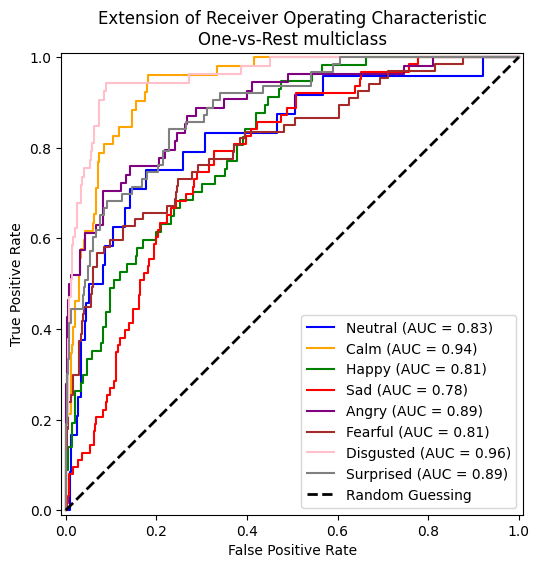

In [36]:
# Define target names (ensure they match your dataset's class order)
target_names = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgusted', 'Surprised']

# Check the number of unique labels and logits' output size
n_classes_model = np.array(all_logits).shape[1]
unique_classes = np.unique(all_labels)
n_classes_labels = len(unique_classes)
n_classes_target = len(target_names)

print(f"Model output classes: {n_classes_model}, Unique labels: {n_classes_labels}, Target names: {n_classes_target}")

if n_classes_model != n_classes_target or n_classes_labels != n_classes_target:
    raise ValueError(
        f"Class mismatch:\nModel output: {n_classes_model}, Labels: {n_classes_labels}, Target names: {n_classes_target}"
    )

# Binarize the labels
label_binarizer = LabelBinarizer()
y_onehot_test = label_binarizer.fit_transform(all_labels)

# Convert logits to probabilities for ROC computation
y_score = torch.nn.functional.softmax(torch.tensor(all_logits), dim=1).numpy()

# Plot ROC curve
colors = cycle(["blue", "orange", "green", "red", "purple", "brown", "pink", "gray"])
fig, ax = plt.subplots(figsize=(6, 6))

for class_id, color in zip(range(n_classes_target), colors):
    RocCurveDisplay.from_predictions(
        y_true=y_onehot_test[:, class_id],
        y_pred=y_score[:, class_id],
        name=f"{target_names[class_id]}",
        color=color,
        ax=ax
    )

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guessing')
ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nOne-vs-Rest multiclass"
)
ax.legend(loc="lower right")

plt.show()

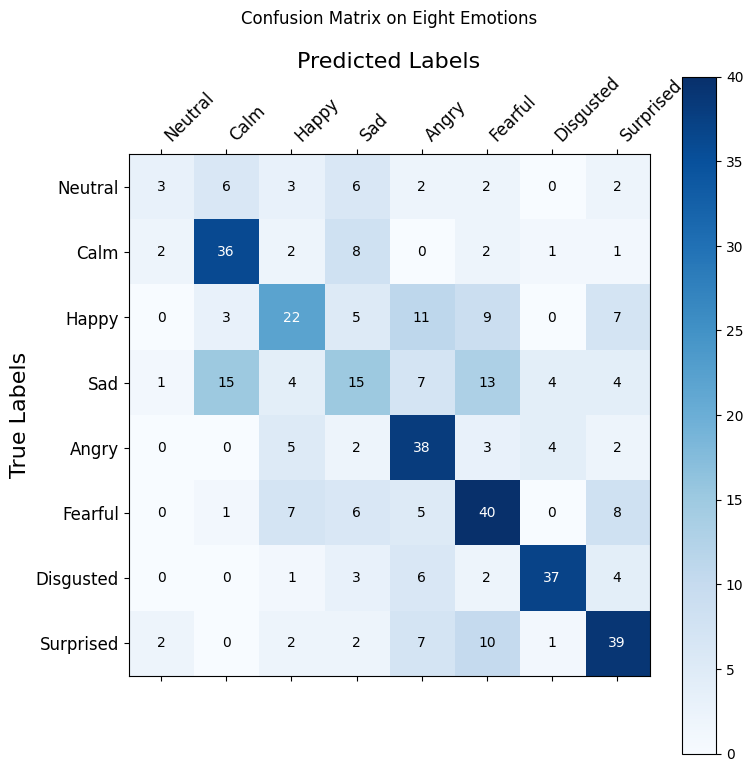

In [ ]:
def generate_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, target_names: list) -> np.ndarray:
    """
    Generate a confusion matrix with consistent label order from target_names.
    
    Parameters:
    - y_true: Array of true labels.
    - y_pred: Array of predicted labels.
    - target_names: List of all possible class labels in the correct order.
    
    Returns:
    - Confusion matrix as a NumPy array.
    """
    # Map target names to indices
    label_to_index = {label: idx for idx, label in enumerate(range(len(target_names)))}
    num_labels = len(target_names)
    conf_matrix = np.zeros((num_labels, num_labels), dtype=int)

    for true_label, pred_label in zip(y_true, y_pred):
        true_index = true_label
        pred_index = pred_label
        conf_matrix[true_index, pred_index] += 1

    return conf_matrix


def confusion_matrix_vis(conf_matrix: np.ndarray, target_names: list):
    """
    Visualize a confusion matrix with clear annotations and class labels.
    
    Parameters:
    - conf_matrix: The confusion matrix as a NumPy array.
    - target_names: List of class labels corresponding to the matrix dimensions.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    cmap = plt.cm.Blues
    cax = ax.matshow(conf_matrix, cmap=cmap)
    plt.colorbar(cax)

    # Labels
    ax.set_xlabel('Predicted Labels', fontsize=16)
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('True Labels', fontsize=16)

    # Tick marks and labels
    ax.set_xticks(range(len(target_names)))
    ax.set_yticks(range(len(target_names)))
    ax.set_xticklabels(target_names, rotation=45, ha="left", fontsize=12)
    ax.set_yticklabels(target_names, fontsize=12)

    # Annotate each cell with its count
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, f"{val}", ha='center', va='center', 
                color='white' if val > conf_matrix.max() / 2 else 'black')

    plt.title("Confusion Matrix on Eight Emotions", pad=20)
    plt.tight_layout()
    plt.show()

target_names = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgusted', 'Surprised']

# Generate confusion matrix
conf_matrix = generate_confusion_matrix(all_labels, all_preds, target_names)
confusion_matrix_vis(conf_matrix, target_names)

In [ ]:
# Get data from checkpoint
checkpoint = torch.load("resnet101_checkpoint_nr_0.001.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

all_preds = []
all_labels = []
all_logits = []

# Evaluate the model
with torch.no_grad():
    for inputs, labels in nr_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_logits.extend(outputs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

Test Accuracy: 0.5958

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.44      0.41        25
           1       0.67      0.88      0.76        64
           2       0.46      0.52      0.49        62
           3       0.38      0.57      0.46        49
           4       0.70      0.58      0.63        45
           5       0.70      0.42      0.52        67
           6       0.78      0.51      0.61        61
           7       0.74      0.77      0.75        60

    accuracy                           0.60       433
   macro avg       0.60      0.58      0.58       433
weighted avg       0.62      0.60      0.60       433


Confusion Matrix:
[[11 10  3  1  0  0  0  0]
 [ 0 56  1  5  0  1  0  1]
 [ 9  3 32  8  0  3  2  5]
 [ 5  2  6 28  3  3  2  0]
 [ 1  3  8  1 26  0  3  3]
 [ 2  2  9 18  1 28  1  6]
 [ 1  5  6 10  5  2 31  1]
 [ 0  2  4  2  2  3  1 46]]


Model output classes: 8, Unique labels: 8, Target names: 8


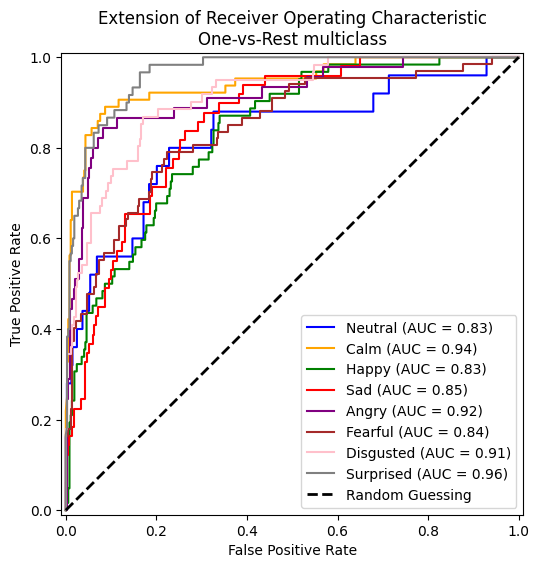

In [39]:
# Define target names (ensure they match your dataset's class order)
target_names = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgusted', 'Surprised']

# Check the number of unique labels and logits' output size
n_classes_model = np.array(all_logits).shape[1]
unique_classes = np.unique(all_labels)
n_classes_labels = len(unique_classes)
n_classes_target = len(target_names)

print(f"Model output classes: {n_classes_model}, Unique labels: {n_classes_labels}, Target names: {n_classes_target}")

if n_classes_model != n_classes_target or n_classes_labels != n_classes_target:
    raise ValueError(
        f"Class mismatch:\nModel output: {n_classes_model}, Labels: {n_classes_labels}, Target names: {n_classes_target}"
    )

# Binarize the labels
label_binarizer = LabelBinarizer()
y_onehot_test = label_binarizer.fit_transform(all_labels)

# Convert logits to probabilities for ROC computation
y_score = torch.nn.functional.softmax(torch.tensor(all_logits), dim=1).numpy()

# Plot ROC curve
colors = cycle(["blue", "orange", "green", "red", "purple", "brown", "pink", "gray"])
fig, ax = plt.subplots(figsize=(6, 6))

for class_id, color in zip(range(n_classes_target), colors):
    RocCurveDisplay.from_predictions(
        y_true=y_onehot_test[:, class_id],
        y_pred=y_score[:, class_id],
        name=f"{target_names[class_id]}",
        color=color,
        ax=ax
    )

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guessing')
ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nOne-vs-Rest multiclass"
)
ax.legend(loc="lower right")

plt.show()

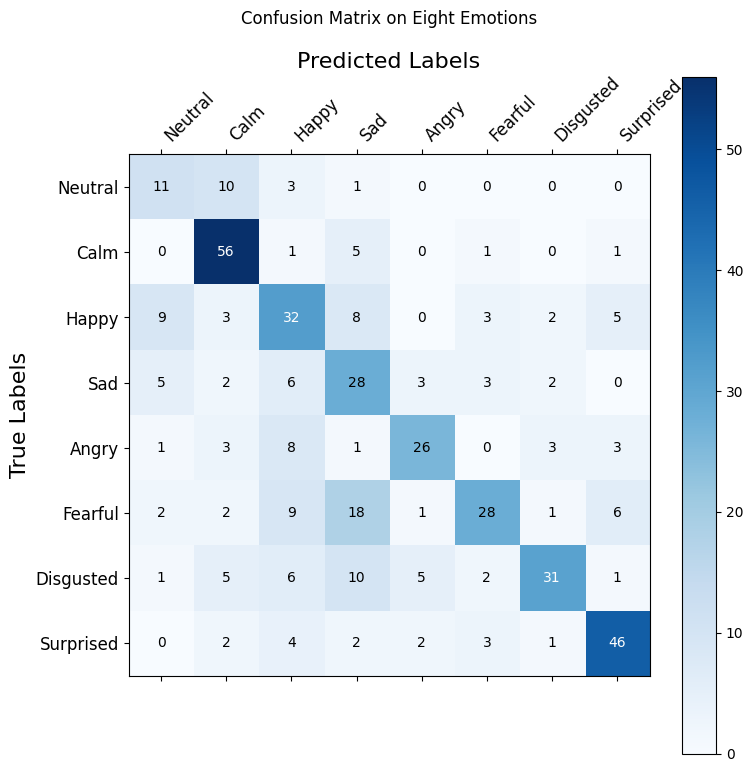

In [ ]:
def generate_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, target_names: list) -> np.ndarray:
    """
    Generate a confusion matrix with consistent label order from target_names.
    
    Parameters:
    - y_true: Array of true labels.
    - y_pred: Array of predicted labels.
    - target_names: List of all possible class labels in the correct order.
    
    Returns:
    - Confusion matrix as a NumPy array.
    """
    # Map target names to indices
    label_to_index = {label: idx for idx, label in enumerate(range(len(target_names)))}
    num_labels = len(target_names)
    conf_matrix = np.zeros((num_labels, num_labels), dtype=int)

    for true_label, pred_label in zip(y_true, y_pred):
        true_index = true_label
        pred_index = pred_label
        conf_matrix[true_index, pred_index] += 1

    return conf_matrix


def confusion_matrix_vis(conf_matrix: np.ndarray, target_names: list):
    """
    Visualize a confusion matrix with clear annotations and class labels.
    
    Parameters:
    - conf_matrix: The confusion matrix as a NumPy array.
    - target_names: List of class labels corresponding to the matrix dimensions.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    cmap = plt.cm.Blues
    cax = ax.matshow(conf_matrix, cmap=cmap)
    plt.colorbar(cax)

    # Labels
    ax.set_xlabel('Predicted Labels', fontsize=16)
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('True Labels', fontsize=16)

    # Tick marks and labels
    ax.set_xticks(range(len(target_names)))
    ax.set_yticks(range(len(target_names)))
    ax.set_xticklabels(target_names, rotation=45, ha="left", fontsize=12)
    ax.set_yticklabels(target_names, fontsize=12)

    # Annotate each cell with its count
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, f"{val}", ha='center', va='center', 
                color='white' if val > conf_matrix.max() / 2 else 'black')

    plt.title("Confusion Matrix on Eight Emotions", pad=20)
    plt.tight_layout()
    plt.show()

target_names = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgusted', 'Surprised']

# Generate confusion matrix
conf_matrix = generate_confusion_matrix(all_labels, all_preds, target_names)
confusion_matrix_vis(conf_matrix, target_names)